# Ciencia de datos (CC408) - Primavera 2024

## Trabajo Práctico 1 - Parte 2

### Reglas de formato y presentation
- El trabajo debe tener una extensión máxima de 8 páginas (no se permite Apéndice). Se espera una buena redacción en la resolución del práctico.
- El informe debe ser entregado en formato PDF, con los gráficos e imágenes en este mismo archivo.
- Entregar el código con los comandos utilizados, identificando claramente a qué inciso corresponde cada comando.

### Fecha de entrega:
Miércoles 2 de octubre a las 23:59 hs.

### Modalidad de entrega
- Al finalizar el trabajo práctico deben hacer un último <i>commit</i> en su repositorio de GitHub llamado “Entrega final del tp”. 
- Asegurense de haber creado una carpeta llamada TP1. Este Jupyter Notebook y el correspondiente al TP1 - Parte 2 deben estar dentro de esa carpeta.
- También deben enviar el link de su repositorio -para que pueda ser clonado y corregido- al siguiente email: ispiousas@udesa.edu.ar
- La última versión en el repositorio es la que será evaluada. Por lo que es importante que: 
    - No envien el correo hasta no haber terminado y estar seguros de que han hecho el <i>commit y push</i> a la versión final que quieren entregar. Debido a que se pueden tomar hasta 3 días de extensión a lo largo del curso, no se corregirán sus tareas hasta no recibir el correo.
    - No hagan nuevos <i>push</i> despues de haber entregado su versión final. Esto generaría confusión acerca de que versión es la que quieren que se les corrija. 

### Parte I: Limpieza de la base

#### Ejercicio 1
La base de datos provista contiene información sobre oferentes de Airbnb en la ciudad de Nueva York. Realicen una limpieza de la base.
- Tengan en cuenta si hay valores duplicados y eliminénlos.
- Eliminen las columnas que no tienen información de interés.
- (Opcional) Luego de leer el artículo __[Missing-data imputation](https://bookdown.org/mike/data_analysis/imputation-missing-data.html##imputation-missing-data)__ (__[Missing-data imputation articulo alternativo](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)__), decidan qué hacer con los missing values e implementen su decision. Justifiquen su eleccion. Pueden usar informacion del paper mencionado o de otras fuentes (citenlas si las usan) para explicar los problemas que pueden surgir por su estrategia elegida.
- Si hay observaciones con *outliers* o valores que no tienen sentido, tomen una decision. Expliquen las decisiones tomadas.
- Transformen las variables **‘neighbourhood_group’** y **‘room_type’** a variables numericas.
- Con la ayuda de los comandos <code>groupby</code> y <code>join</code> o <code>merge</code>, creen una columna que tenga la cantidad de oferentes por “Neighbourhood group”. Llamen a esa nueva columna <code>offer group</code>

In [1]:
# Resolver acá
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# base tizi
base_airbnb_original = pd.read_csv(r"C:\Users\tizip\OneDrive\Documentos\Tizi UdeSA\8- Ciencia de datos\CC408-T1-4\TP2 probar\TP2\Base Airbnb NY.csv")

# base angie
#base_airbnb_original = pd.read_csv(r'/Users/angelanavajas/Desktop/Ciencia de datos/CC408-T1-4/TP2 probar/TP2/Base Airbnb NY.csv')

print(base_airbnb_original)

             id                                               name   host_id  \
0          2539                 Clean & quiet apt home by the park      2787   
1          2595                              Skylit Midtown Castle      2845   
2          3647                THE VILLAGE OF HARLEM....NEW YORK !      4632   
3          3831                    Cozy Entire Floor of Brownstone      4869   
4          5022   Entire Apt: Spacious Studio/Loft by central park      7192   
...         ...                                                ...       ...   
48900  19454344  Perfect ap in Manhattan! Walking to Central Park!  11670284   
48901  36224876                   Upper East Side Apt By The Water  46232598   
48902  21869051                        Comfy Apt in NYC Brownstone  97243693   
48903   3004563                                           The spot  15303460   
48904  19712687               Sunny, spacious, homey Brooklyn loft  11989253   

         host_name neighbourhood_group 

In [3]:
# Elimino datos vacios
base_airbnb_limpia = base_airbnb_original.dropna()

# Elimino datos duplicados
base_airbnb_limpia = base_airbnb_limpia.drop_duplicates()

# Elimino columnas que no nos interesan: los nombres del host ni del lugar, como los id, no nos interesan ya que no nos son relevantes a la hora de hacer predicciones 
base_airbnb_limpia = base_airbnb_limpia.drop(columns=['id','name','host_name','host_id'])

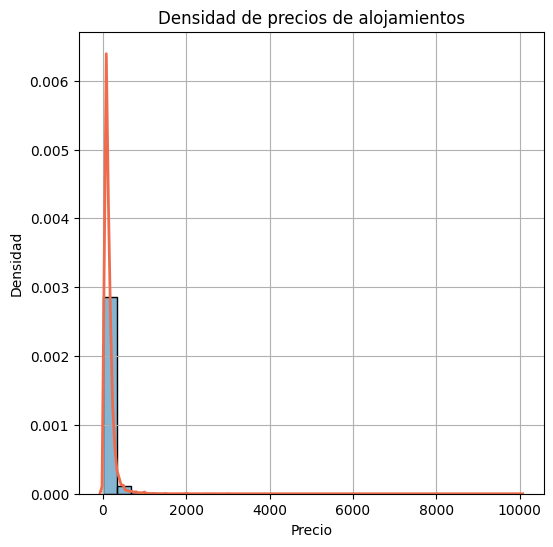

In [4]:
### DENSIDAD DE PRECIOS DE ALOJAMIENTOS --> VER OUTLIERS
plt.figure(figsize=(6, 6))
sns.histplot(base_airbnb_limpia['price'], bins = 30, color = '#3685B5', kde = False, stat = "density", alpha = 0.6)
sns.kdeplot(base_airbnb_limpia['price'], color = '#EE6C4D', linewidth = 2)
plt.title('Densidad de precios de alojamientos')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.grid()
plt.show()

In [5]:
# OUTLIERS DE PRECIO POR TIPO DE HABITACION POR LOCALIDAD
Q1_1 = base_airbnb_limpia.groupby(['neighbourhood_group', 'room_type'])['price'].quantile(0.25)
Q3_1 = base_airbnb_limpia.groupby(['neighbourhood_group', 'room_type'])['price'].quantile(0.75)
IQR_1 = Q3_1 - Q1_1
lower_precio_hab_loc = Q1_1 - 1.5 * IQR_1
upper_precio_hab_loc = Q3_1 + 1.5 * IQR_1

# Crear un DataFrame con los límites de los cuantiles
limits_precio_hab_loc = pd.DataFrame({'lower_precio_hab_loc': lower_precio_hab_loc, 'upper_precio_hab_loc': upper_precio_hab_loc}).reset_index()
# Unir los límites al DataFrame original en los localidad
base_airbnb_limpia = pd.merge(base_airbnb_limpia, limits_precio_hab_loc, on = ['neighbourhood_group', 'room_type'])

# me quedo solo con los datos uqe son mayor o igual a "lower" y menor o igual a "upper"
base_airbnb_limpia = base_airbnb_limpia[
    (base_airbnb_limpia['price'] >= base_airbnb_limpia['lower_precio_hab_loc']) & 
    (base_airbnb_limpia['price'] <= base_airbnb_limpia['upper_precio_hab_loc'])]

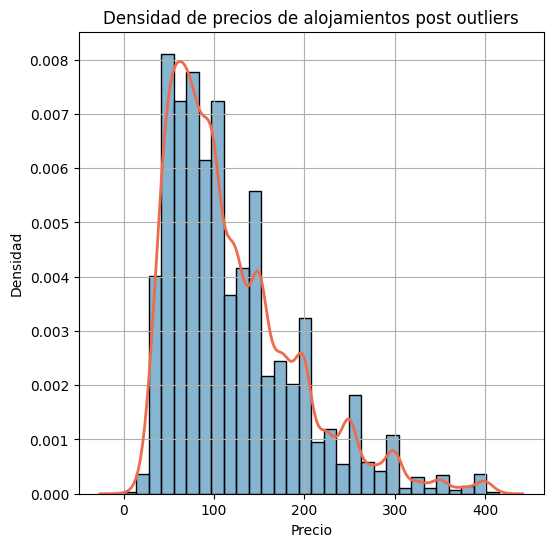

In [6]:
# DENSIDAD DE PRECIOS DE ALOJAMIENTOS POST OUTLIERS
plt.figure(figsize=(6, 6))
sns.histplot(base_airbnb_limpia['price'], bins = 30, color = '#3685B5', kde = False, stat = "density", alpha = 0.6)
sns.kdeplot(base_airbnb_limpia['price'], color = '#EE6C4D', linewidth = 2)
plt.title('Densidad de precios de alojamientos post outliers')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.grid()
plt.show()

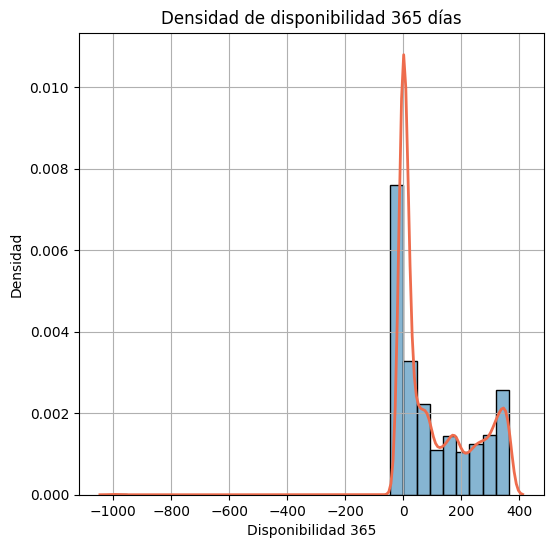

In [7]:
### DENSIDAD DE DISPONIBILIDAD 365 --> VER OUTLIERS
plt.figure(figsize=(6, 6))
sns.histplot(base_airbnb_limpia['availability_365'], bins = 30, color = '#3685B5', kde = False, stat = "density", alpha = 0.6)
sns.kdeplot(base_airbnb_limpia['availability_365'], color = '#EE6C4D', linewidth = 2)
plt.title('Densidad de disponibilidad 365 días')
plt.xlabel('Disponibilidad 365')
plt.ylabel('Densidad')
plt.grid()
plt.show()

In [8]:
# OUTLIERS DISPONIBILIDAD POR LOCALIDAD
Q1_3 = base_airbnb_limpia.groupby('neighbourhood_group')['availability_365'].quantile(0.25)
Q3_3 = base_airbnb_limpia.groupby('neighbourhood_group')['availability_365'].quantile(0.75)
IQR_3 = Q3_3 - Q1_3
lower_disp_loc = Q1_3 - 1.5 * IQR_3
upper_disp_loc = Q3_3 + 1.5 * IQR_3

# Crear un DataFrame con los límites de los cuantiles
limits_disp_loc = pd.DataFrame({'lower_disp_loc': lower_disp_loc, 'upper_disp_loc': upper_disp_loc}).reset_index()
# Unir los límites al DataFrame original en los localidad
base_airbnb_limpia = pd.merge(base_airbnb_limpia, limits_disp_loc, on = ['neighbourhood_group'])

# me quedo solo con los datos uqe son mayor o igual a "lower" y menor o igual a "upper"
base_airbnb_limpia = base_airbnb_limpia[
    (base_airbnb_limpia['availability_365'] >= base_airbnb_limpia['lower_disp_loc']) & 
    (base_airbnb_limpia['availability_365'] <= base_airbnb_limpia['upper_disp_loc'])]

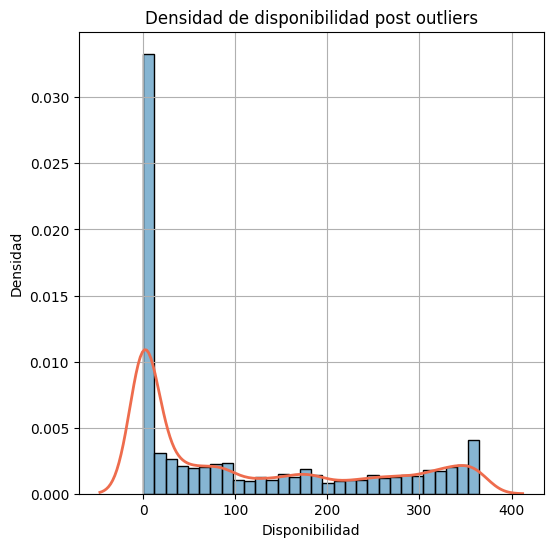

In [9]:
# DENSIDAD DISPONIBILIDAD POST OUTLIERS
plt.figure(figsize=(6, 6))
sns.histplot(base_airbnb_limpia['availability_365'], bins = 30, color = '#3685B5', kde = False, stat = "density", alpha = 0.6)
sns.kdeplot(base_airbnb_limpia['availability_365'], color = '#EE6C4D', linewidth = 2)
plt.title('Densidad de disponibilidad post outliers')
plt.xlabel('Disponibilidad')
plt.ylabel('Densidad')
plt.grid()
plt.show()

In [10]:
print(f"Número de filas antes de eliminar outliers: {base_airbnb_original.shape[0]}")
print(f"Número de filas después de eliminar outliers: {base_airbnb_limpia.shape[0]}")
print(f"Número de outliers:")
print(base_airbnb_original.shape[0]-base_airbnb_limpia.shape[0])

Número de filas antes de eliminar outliers: 48905
Número de filas después de eliminar outliers: 36435
Número de outliers:
12470


In [11]:
# VARIABLES CATEGORICAS A DUMMIES: variables categoricas neighbourhood_group y room_type a variables numericas aplico One-Hot Encoding 
# Separa las categorias de la variable en distintas columnas y le pone valor True si cumple la categoria o False si no
dummies = pd.get_dummies(base_airbnb_limpia[['neighbourhood_group', 'room_type']], drop_first = False)

# Concateno las variables transformadas a la base limpia
base_airbnb_transformadas = pd.concat([base_airbnb_limpia, dummies], axis = 1)

# Columnas a las que me interesa cambiarle los valores de True/False a 0 y 1
columnas = [
    'neighbourhood_group_Brooklyn', 
    'neighbourhood_group_Manhattan', 
    'neighbourhood_group_Queens', 
    'neighbourhood_group_Staten Island', 
    'neighbourhood_group_Bronx',
    'room_type_Private room', 
    'room_type_Shared room',
    'room_type_Entire home/apt']

# Le cambio el valor de True/False en 0 y 1
for col in columnas:
    if col in base_airbnb_transformadas.columns:
        base_airbnb_transformadas[col] = base_airbnb_transformadas[col].astype(int)

# Verificar las columnas finales
print(base_airbnb_transformadas.columns)

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'lower_precio_hab_loc', 'upper_precio_hab_loc',
       'lower_disp_loc', 'upper_disp_loc', 'neighbourhood_group_Bronx',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')


In [12]:
#Creo la nueva variable que cuenta la cantidiad de oferta por localidad
oferta = base_airbnb_transformadas.groupby('neighbourhood_group').size().reset_index(name = 'offer group')
base_airbnb_final = base_airbnb_transformadas.merge(oferta, on ='neighbourhood_group', how = 'left')
print(base_airbnb_final.columns)

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'lower_precio_hab_loc', 'upper_precio_hab_loc',
       'lower_disp_loc', 'upper_disp_loc', 'neighbourhood_group_Bronx',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'offer group'],
      dtype='object')


### Parte II: Graficos y visualizaciones

#### Ejercicio 2
Una vez hecha la limpieza, realicen una matriz de correlación con las siguientes variables:**‘neighbourhood group’, ‘latitude’, ‘longitude’, ‘room type’,‘price’, ‘minimum nights’, ‘number of reviews’, ‘reviews per month’,‘calculated host listings count’, ‘availability 365’.** Comenten los resultados. Utilicen alguno de los comandos disponibles en este link para graficar la matriz de correlacion.

*Nota:* consideren cómo es conveniente incluir las variables que originalmente eran categóricas para poder interpretar mejor la matriz de correlación.

In [13]:
# Lista de variables para al correlacion: no uso las categoricas per se, sino las modificadas
variables_corr =  ['latitude', 'longitude', 'price', 'minimum_nights', 
                   'number_of_reviews', 'reviews_per_month', 
                   'calculated_host_listings_count', 'availability_365',
                   'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 
                   'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 
                   'room_type_Private room', 'room_type_Shared room']

# Creo un nuevo DataFrame con columnas únicas (.loc[:, eso puse para que no me duplique las columnas)
base_airbnb_corr = base_airbnb_final.loc[:, variables_corr]

# Matriz de correlación
matriz_corr = base_airbnb_corr.corr()

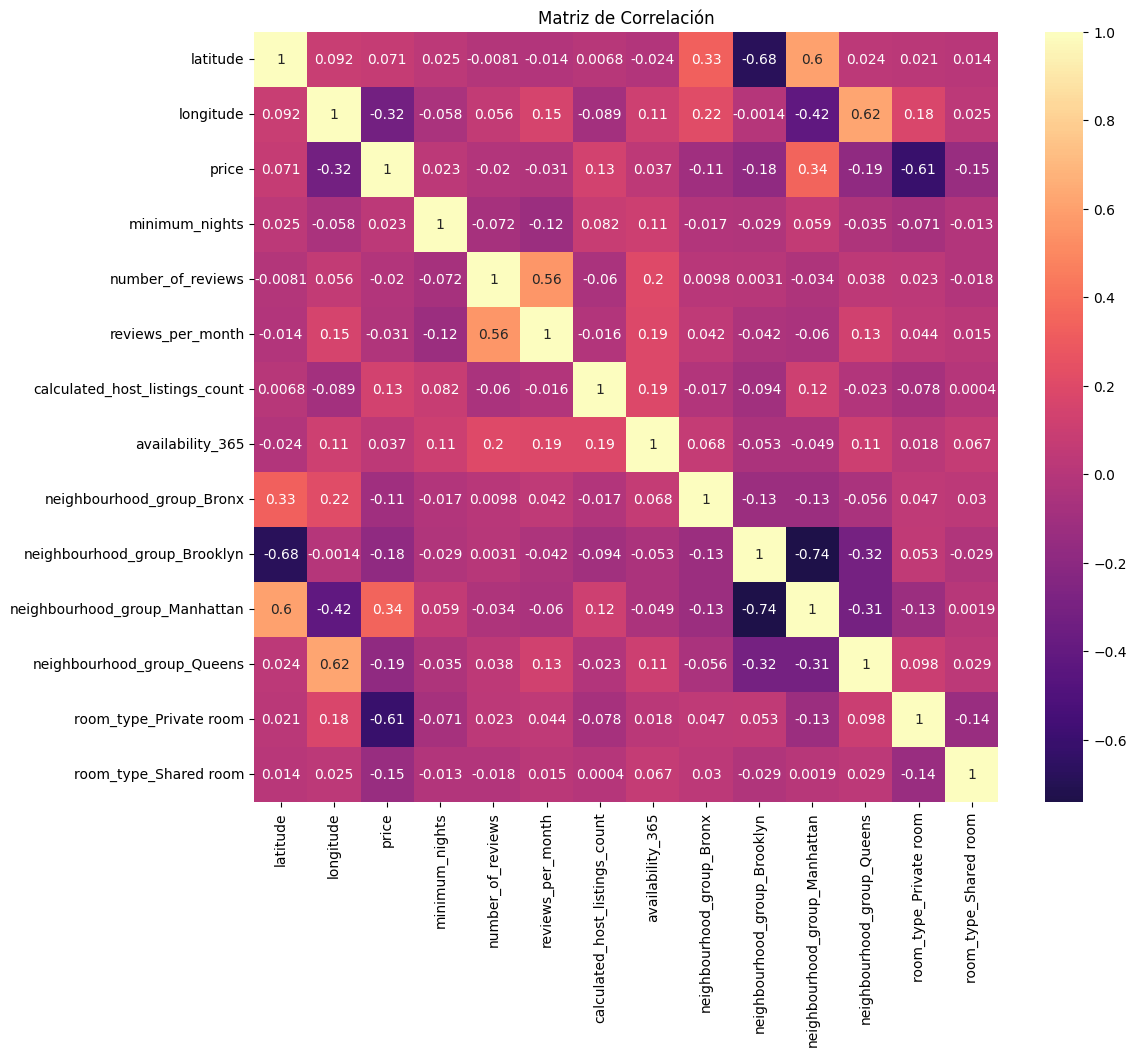

In [14]:
#Grafico la matriz de correlacion
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_corr, annot=True, cmap='magma', center=0)
plt.title('Matriz de Correlación')
plt.show()

#### Ejercicio 3
Respondan las siguientes preguntas: ¿Cuál es la proporción de oferentes por “Neighbourhood group”? ¿Y por tipo de habitación? Además, realicen gráficos para mostrar estas composiciones y comenten los resultados.

Proporción de oferentes por localidades:
neighbourhood_group
Brooklyn         42.60
Manhattan        42.43
Queens           11.85
Bronx             2.28
Staten Island     0.82
Name: proportion, dtype: float64


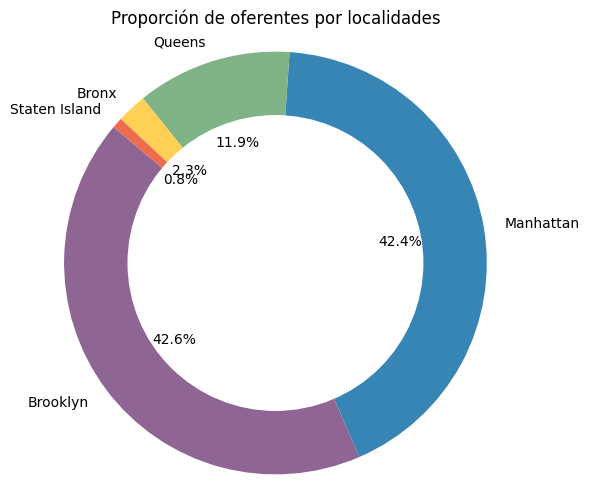

In [15]:
paleta = ['#8F6593', '#3685B5', '#7FB285', '#FFCF56', '#EE6C4D']

# VEO MEDIAS DE OFERTAS POR LOCALIDADES
proporcion_neighbourhood = (base_airbnb_final['neighbourhood_group'].value_counts(normalize=True) * 100).apply(lambda x: int(x * 100) / 100)
print("Proporción de oferentes por localidades:")
print(proporcion_neighbourhood)

# GRAFICO PROPORCION DE OFERENTES POR LOCALIDADES
plt.figure(figsize = (6, 6))
plt.pie(proporcion_neighbourhood, labels=proporcion_neighbourhood.index, autopct='%1.1f%%', startangle=140, colors = paleta)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Proporción de oferentes por localidades')
plt.axis('equal')
plt.show()


Proporción de oferentes por tipo de habitacion:
room_type
Entire home/apt    52.10
Private room       45.76
Shared room         2.12
Name: proportion, dtype: float64


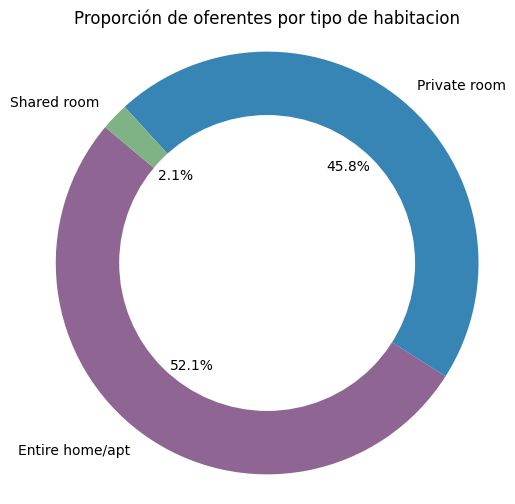

In [16]:
# VEO MEDIAS DE OFERTAS POR TIPO DE HABITACION
proporcion_room_type = (base_airbnb_final['room_type'].value_counts(normalize=True) * 100).apply(lambda x: int(x * 100) / 100)
print("\nProporción de oferentes por tipo de habitacion:")
print(proporcion_room_type)

# GRAFICO PROPORCION DE OFERENTES POR TIPO DE HABITACION
plt.figure(figsize=(6, 6))
plt.pie(proporcion_room_type, labels=proporcion_room_type.index, autopct='%1.1f%%', startangle=140, colors=paleta)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Proporción de oferentes por tipo de habitacion')
plt.axis('equal')
plt.show()


Proporción de oferentes por tipo de habitación por localidad:
neighbourhood_group  room_type      
Bronx                Private room       61.010830
                     Entire home/apt    34.055355
                     Shared room         4.933815
Brooklyn             Entire home/apt    49.539393
                     Private room       48.830767
                     Shared room         1.629840
Manhattan            Entire home/apt    59.782679
                     Private room       38.063515
                     Shared room         2.153806
Queens               Private room       59.027778
                     Entire home/apt    37.708333
                     Shared room         3.263889
Staten Island        Private room       51.333333
                     Entire home/apt    47.000000
                     Shared room         1.666667
Name: proportion, dtype: float64


C:\Users\tizip\AppData\Local\Temp\ipykernel_12836\3791646571.py:11: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(data=proporcion_room_loc, x='neighbourhood_group', y='proporción', hue='room_type', palette = paleta)


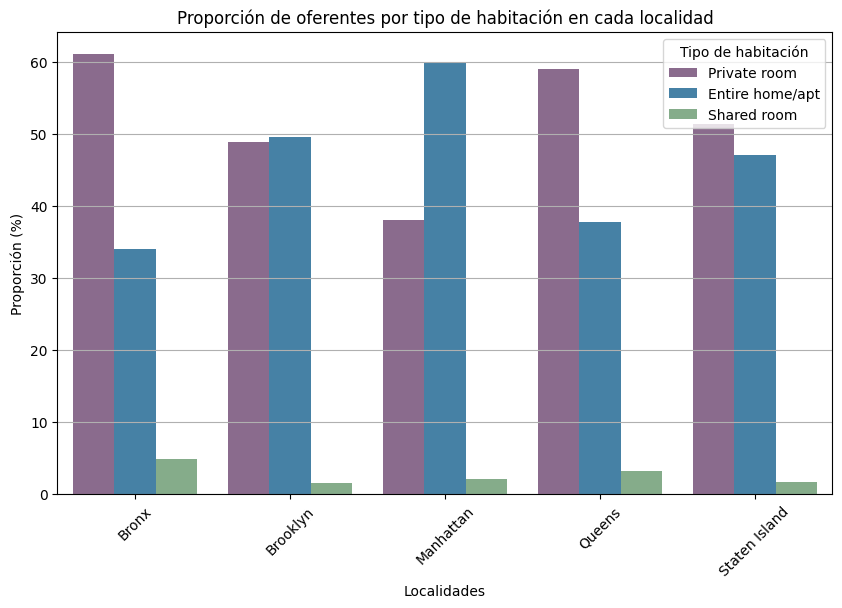

In [17]:
#Aca se ven dividio por localidad las proporciones de cada tipo de cuarto 
proporcion_room_loc = base_airbnb_final.groupby("neighbourhood_group")['room_type'].value_counts(normalize=True) * 100
print("\nProporción de oferentes por tipo de habitación por localidad:")
print(proporcion_room_loc)

# hago esto para poder hacer el histograma
proporcion_room_loc = proporcion_room_loc.reset_index(name='proporción')

# Crear el histograma
plt.figure(figsize=(10, 6))
sns.barplot(data=proporcion_room_loc, x='neighbourhood_group', y='proporción', hue='room_type', palette = paleta)
plt.title("Proporción de oferentes por tipo de habitación en cada localidad")
plt.xlabel("Localidades")
plt.ylabel("Proporción (%)")
plt.xticks(rotation=45)
plt.legend(title="Tipo de habitación")
plt.grid(axis='y')
plt.show()

#### Ejercicio 4
Realicen un histograma de los precios de los alojamientos. Comenten el gráfico obtenido. Además, respondan las siguientes preguntas: ¿cuál es el precio mínimo, máximo y promedio? ¿Cuál es la media de precio por “Neighbourhood group” y por tipo de habitación? 


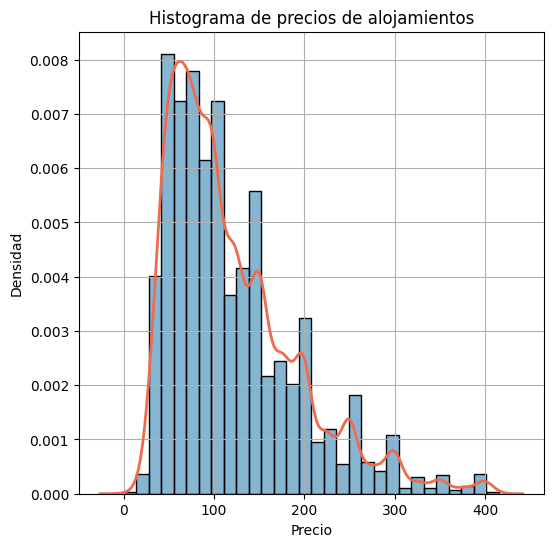

In [18]:
# Resolver acá
plt.figure(figsize=(6, 6))
sns.histplot(base_airbnb_final['price'], bins=30, color='#3685B5', kde=False, stat="density", alpha=0.6)
sns.kdeplot(base_airbnb_final['price'], color='#EE6C4D', linewidth=2)
plt.title('Histograma de precios de alojamientos')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.grid()
plt.show()

In [19]:
# MINIMO, MAXIMO
precio_min = base_airbnb_final['price'].min()
precio_max = base_airbnb_final['price'].max()
precio_prom = base_airbnb_final['price'].mean()
print('Precio Mínimo: ' + str(precio_min))
print('Precio Máximo: ' + str(precio_max))
print(f'Precio Promedio: {precio_prom:.2f}')

Precio Mínimo: 0.0
Precio Máximo: 415.0
Precio Promedio: 119.80


In [20]:
# Media por neighborhood_group
media_neighbourhood = base_airbnb_final.groupby('neighbourhood_group')['price'].mean()
print('Media de Precio por localidad:')
print(media_neighbourhood)

# Media por room_type
media_room_type = base_airbnb_final.groupby('room_type')['price'].mean()
print('\nMedia de Precio por tipo de habitación:')
print(media_room_type)

Media de Precio por localidad:
neighbourhood_group
Bronx             69.732852
Brooklyn         105.047220
Manhattan        148.324365
Queens            82.997454
Staten Island     81.480000
Name: price, dtype: float64

Media de Precio por tipo de habitación:
room_type
Entire home/apt    164.490677
Private room        72.195371
Shared room         49.006468
Name: price, dtype: float64


#### Ejercicio 5
Realicen dos scatter plots con dos variables de interés en cada uno. Comenten.

   neighbourhood_group        room_type       price
0                Bronx  Entire home/apt  102.925795
1                Bronx     Private room   53.919132
2                Bronx      Shared room   36.170732
3             Brooklyn  Entire home/apt  147.134460
4             Brooklyn     Private room   64.671636
5             Brooklyn      Shared room   35.466403
6            Manhattan  Entire home/apt  188.868225
7            Manhattan     Private room   89.346304
8            Manhattan      Shared room   65.258258
9               Queens  Entire home/apt  123.376304
10              Queens     Private room   59.671373
11              Queens      Shared room   38.347518
12       Staten Island  Entire home/apt  111.624113
13       Staten Island     Private room   54.655844
14       Staten Island      Shared room   57.600000


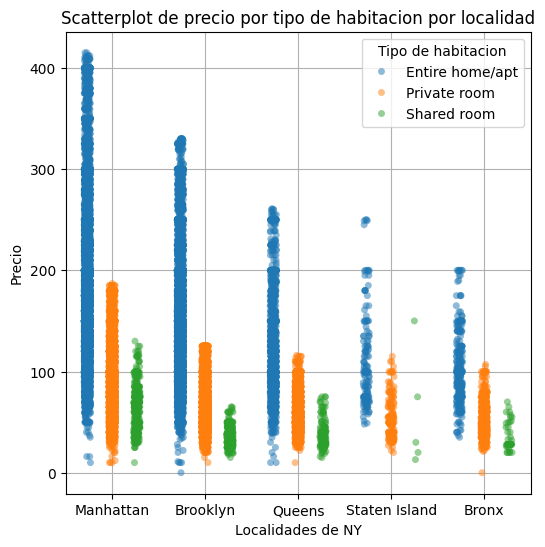

In [21]:
# SCATTERPLOT PRECIO POR HABITACION POR LOCALIDAD
means_precio_hab_loc_out = base_airbnb_limpia.groupby(['neighbourhood_group', 'room_type'])['price'].mean().reset_index()
print(means_precio_hab_loc_out)

plt.figure(figsize=(6, 6))
sns.stripplot(data = base_airbnb_limpia, x = "neighbourhood_group", y = "price", hue = "room_type", dodge = True, alpha = 0.5)
plt.title("Scatterplot de precio por tipo de habitacion por localidad") 
plt.xlabel ("Localidades de NY")
plt.ylabel ("Precio")
plt.legend(title = "Tipo de habitacion")
plt.grid()
plt. show()

  neighbourhood_group  availability_365
0               Bronx        168.202166
1            Brooklyn        103.117761
2           Manhattan        103.765604
3              Queens        147.847454
4       Staten Island        205.710000


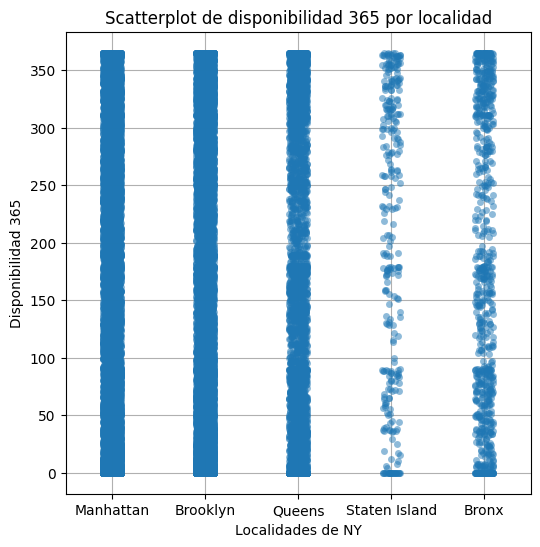

In [22]:
# SCATTERPLOT DE DISPONIBILIDAD 365 POR LOCALIDAD
means_min_hab_loc = base_airbnb_limpia.groupby('neighbourhood_group')['availability_365'].mean().reset_index()
print(means_min_hab_loc)

plt.figure(figsize=(6, 6))
sns.stripplot(data = base_airbnb_limpia, x = "neighbourhood_group", y = "availability_365", dodge = True, alpha = 0.5)
plt.title("Scatterplot de disponibilidad 365 por localidad")
plt.xlabel("Localidades de NY")
plt.ylabel("Disponibilidad 365")
plt.grid()
plt.show()

#### Ejercicio 6
Utilicen el análisis de componentes principales para graficar las variables en dos dimensiones. Comenten los resultados obtenidos (qué porcentaje de la varianza se logra explicar con dos componentes, cómo son los *loadings*, si ven algún patrón en el gráfico).

In [23]:
# Resolver acá
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [24]:
# Me quedo solo con las columnas de las variables numericas
variables_pca = ['latitude', 'longitude', 'price', 'minimum_nights', 
                 'number_of_reviews', 'reviews_per_month', 
                 'calculated_host_listings_count', 'availability_365', 'offer group','neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
                 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
                 'room_type_Entire home/apt', 'room_type_Private room',
                 'room_type_Shared room', 'offer group']

base_variables_pca = base_airbnb_final.loc[:, variables_pca]

Text(0.5, 1.0, 'Correlation matrix')

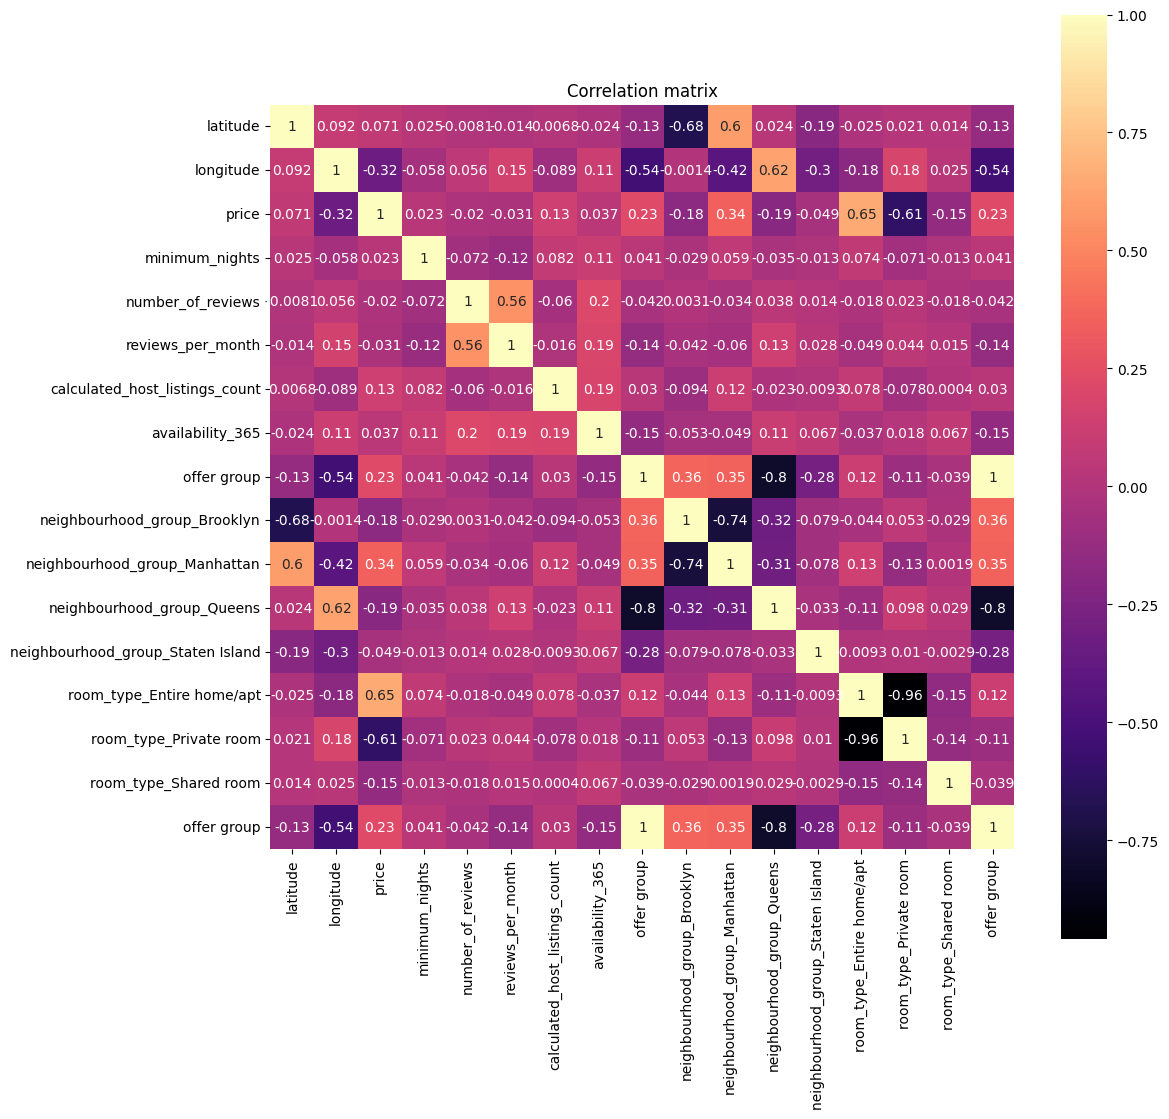

In [25]:
# vemos la matriz de correlacion
correlation = base_variables_pca.corr()
plt.figure(figsize = (12,12))
sns.heatmap(correlation, vmax = 1, square = True, annot = True, cmap = 'magma')
plt.title('Correlation matrix')

In [26]:
# Escalamos las variables para poder ver de nuevo las correlaciones
# Inicializamos el transformador
scaler = StandardScaler(with_std=True, with_mean=True)
# Aplicamos fit_transform al DataFrame
base_airbnb_pca_transformada = pd.DataFrame(scaler.fit_transform(base_variables_pca), columns=base_variables_pca.columns)

Text(0.5, 1.0, 'Correlation matrix escalada')

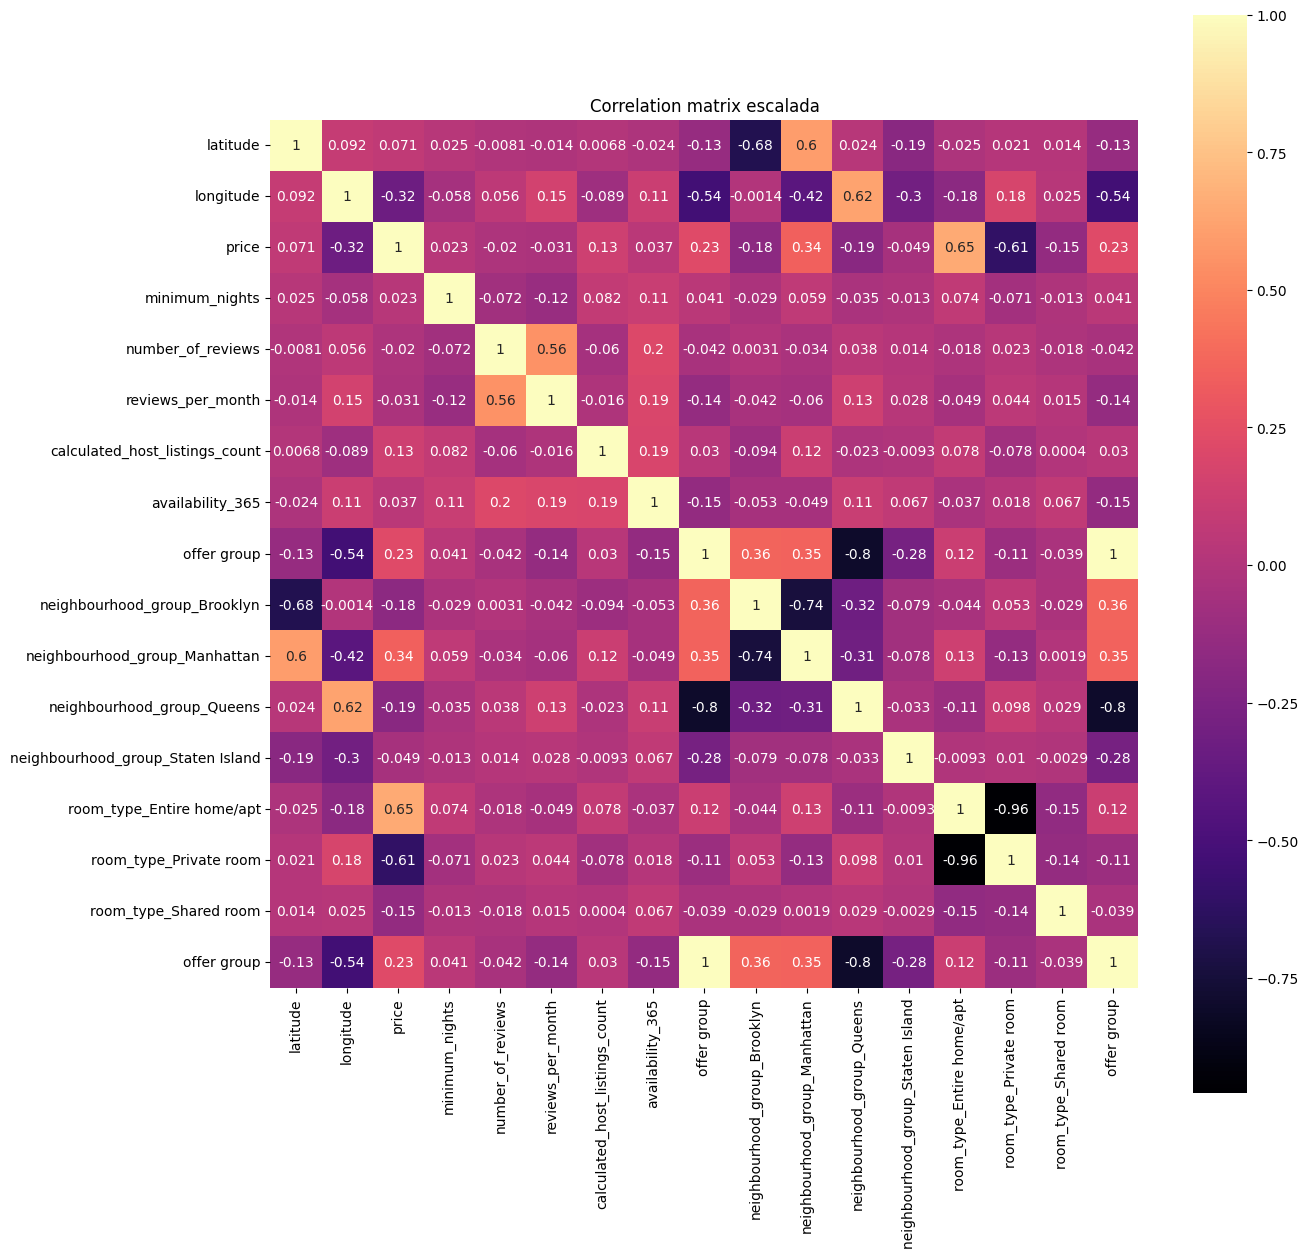

In [27]:
# veo matriz de correlacion
correlation_escalada = base_airbnb_pca_transformada.corr()
plt.figure(figsize=(14,14))
sns.heatmap(correlation_escalada, vmax=1, square=True,annot=True,cmap='magma')
plt.title('Correlation matrix escalada')

In [28]:
# Ajustamos el modelo PCA
pca = PCA(n_components = 2)
base_airbnb_pca = pca.fit_transform(base_airbnb_pca_transformada) # ya son los datos normalizados

In [29]:
# % de la Varianza explicada por los componentes 
print("Varianza explicada por componente:", pca.explained_variance_ratio_)
varianza_total = sum(pca.explained_variance_ratio_)
print("Varianza total explicada:", varianza_total)

Varianza explicada por componente: [0.22569539 0.15514144]
Varianza total explicada: 0.3808368285824658


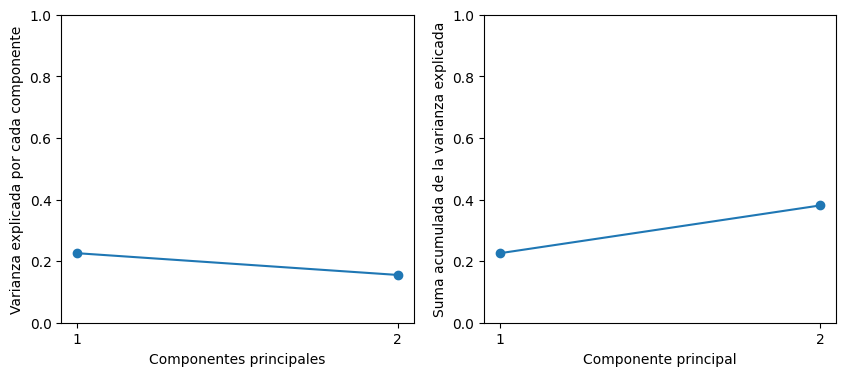

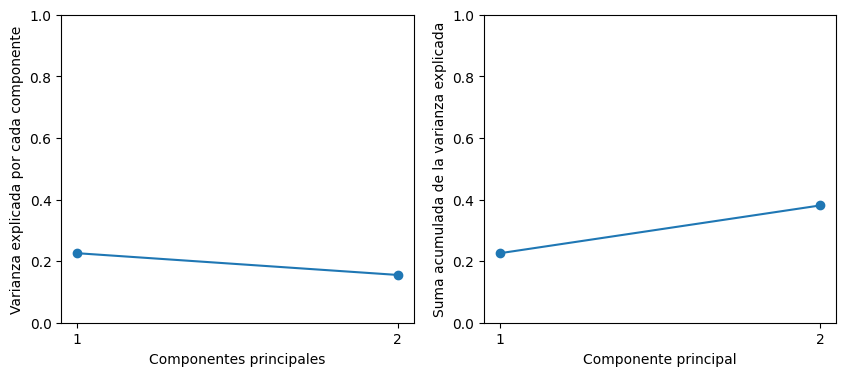

In [35]:
# veo graficamente la varianza explicada por cada componente y la total de los componentes
fig, axes = plt.subplots(1, 2, figsize=(10, 4)) # 2 subplots uno al lado del otro
ticks = np.arange(pca.n_components_)+1 # para crear ticks en el eje horizontal
ax = axes[0]
ax.plot(ticks, pca.explained_variance_ratio_ , marker='o')
ax.set_xlabel('Componentes principales');
ax.set_ylabel('Varianza explicada por cada componente')
ax.set_ylim([0,1])
ax.set_xticks(ticks)

ax = axes[1]
ax.plot(ticks, pca.explained_variance_ratio_.cumsum(), marker='o') 
ax.set_xlabel('Componentees principales')
ax.set_ylabel('Suma acumulada de la varianza explicada')
ax.set_ylim([0, 1])
ax.set_xticks(ticks)
fig
# capture suprime la visualización de la figura parcialmente terminada

In [36]:
# Loadings vectors
loading_pca = pca.components_ # cada fila corresponde a un CP y cada columna, a una variable
print("Loadings:\n", pca.components_)

Loadings:
 [[-0.01202368 -0.36716256  0.27627173  0.04966791 -0.06724911 -0.12259277
   0.05544801 -0.09255521  0.44717824  0.07639897  0.25309861 -0.41586003
  -0.0646401   0.23612848 -0.22542795 -0.03920385  0.44717824]
 [-0.39707696 -0.00649084 -0.31170418 -0.05231368 -0.00646543 -0.03089304
  -0.11127461 -0.06912615  0.21598213  0.52800877 -0.3742879  -0.18064193
  -0.02089518 -0.29898968  0.29931234  0.00168158  0.21598213]]


In [37]:
#Calculo los scores
scores = base_airbnb_pca 
print("Scores:\n",scores)

Scores:
 [[ 1.70991451  1.93063575]
 [ 0.16130771 -0.96398805]
 [ 1.17619679  1.44623111]
 ...
 [-5.32776707  0.88923659]
 [-2.64931673  2.34702904]
 [-0.47129186 -2.52989883]]


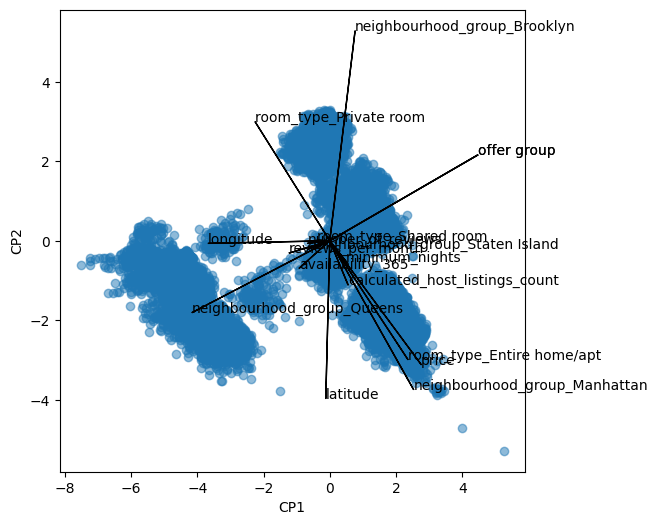

In [38]:
# Visualizamos features y loadings
i, j = 0, 1 # Componentes
scale_arrow = s_ = 10 # para extender la longitud de las flechas y que se vean mejor
scores[:,1] *= -1

fig, ax = plt.subplots(1, 1, figsize=(6, 6)) # creamos 1 subplot
ax.scatter(scores[:,0], scores[:,1], alpha = 0.5) # graficamos los valores de los CP1 y CP2
ax.set_xlabel('CP%d' % (i+1))
ax.set_ylabel('CP%d' % (j+1))
for k in range(pca.components_.shape[1]): # loop que itera por la cantidad de features
    ax.arrow(0, 0, s_*pca.components_[i,k], s_*pca.components_[j,k]) # flecha desde el origen (0) a las coordenadas
    ax.text(s_*pca.components_[i,k], s_*pca.components_[j,k], base_variables_pca.columns[k]) # al final de cada flecha, nombre de la variable

### Parte III: Predicción


El objetivo de esta parte del trabajo es intentar predecir los precios de los alojamientos.

#### Ejercicio 7
Eliminen de la base todas las variables relacionadas al precio

In [39]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

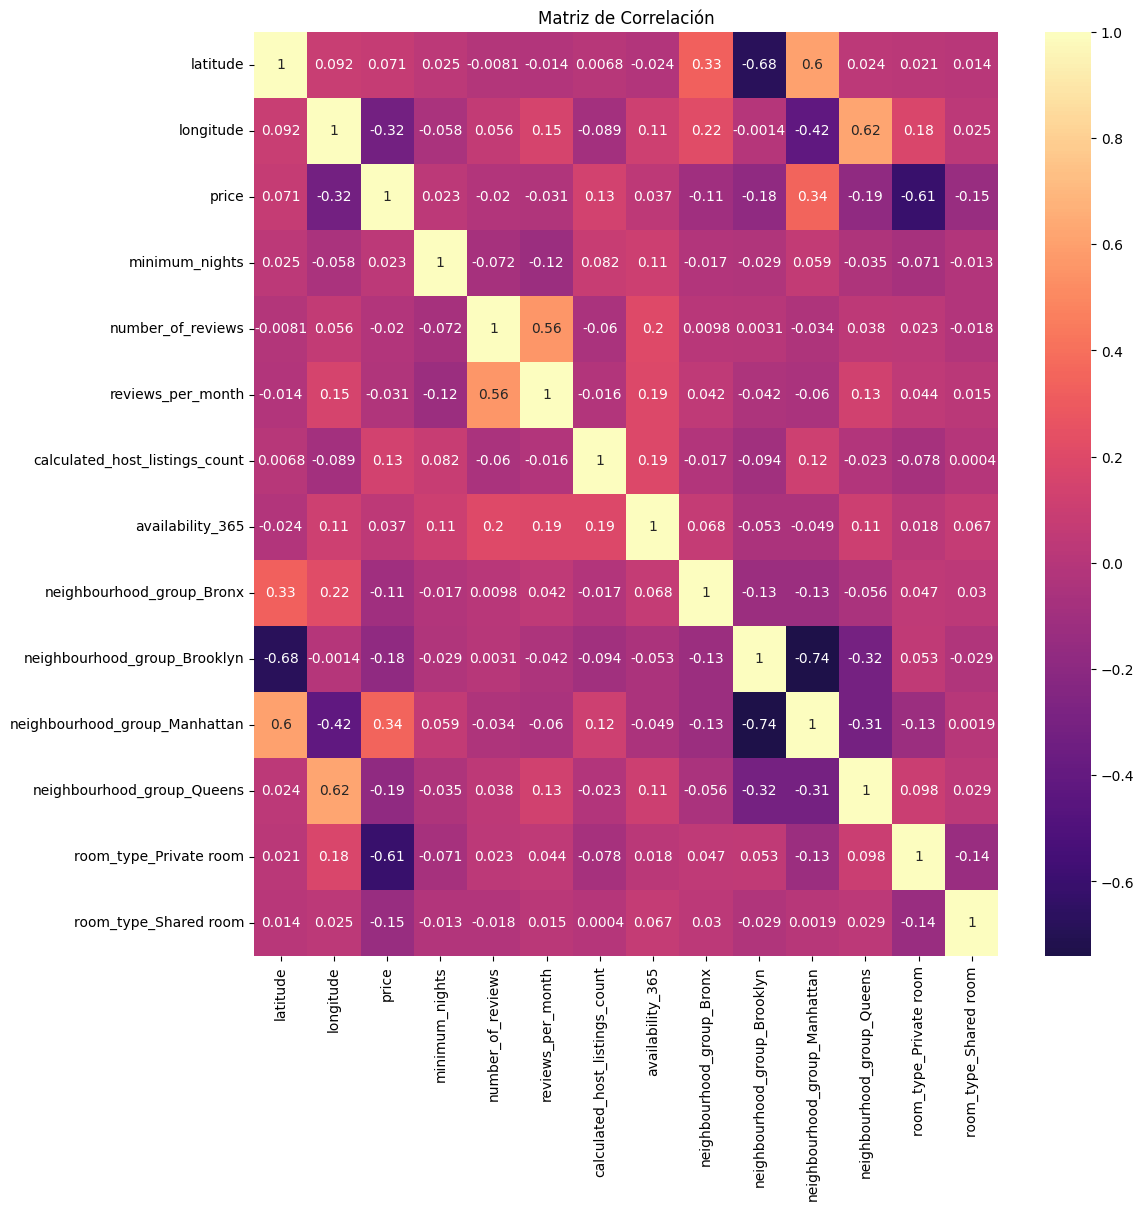

In [40]:
# veo la matriz de correlacion para saber que variable eliminar de la base
plt.figure(figsize=(12, 12))
sns.heatmap(matriz_corr, annot=True, cmap='magma', center=0)
plt.title('Matriz de Correlación')
plt.show()

In [41]:
# elimino las variables relacionadas a price y las categoricas que no permiten hacer analisis de prediccion
variables_eliminar = ['room_type_Private room', 'longitude', 'neighbourhood_group_Manhattan', "neighbourhood_group", "neighbourhood", "room_type", "last_review"]
base_airbnb_regresion = base_airbnb_final.drop(columns=variables_eliminar, errors='ignore')
print(base_airbnb_regresion.columns)

Index(['latitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'lower_precio_hab_loc', 'upper_precio_hab_loc',
       'lower_disp_loc', 'upper_disp_loc', 'neighbourhood_group_Bronx',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Shared room', 'offer group'],
      dtype='object')


#### Ejercicio 8
Partan la base en una base de prueba (test) y una de entrenamiento (train) utilizando el comando <code>train_test_split</code>. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (*random state instance*) debe ser 201. Establezca a price como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables serán las variables independientes (matriz X). Recuerden agregar la columna de unos (1).

In [42]:
# Separar las variables en dependientes e independientes
x = base_airbnb_regresion.drop(['price'], axis = 1)
y = base_airbnb_regresion['price']

# Columna de unos
x['ones'] = 1

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 201)

# Imrpimo los resultados
print("Conjunto de entrenamiento (X):")
print(x_train)
print("\nConjunto de prueba (X):")
print(x_test)
print("\nConjunto de entrenamiento (y):")
print(y_train)
print("\nConjunto de prueba (y):")
print(y_test)

# Mostrar las dimensiones de los conjuntos para verificar
print(f"Conjunto de entrenamiento (x_train): {X_train.shape}")
print(f"Conjunto de prueba (x_test): {X_test.shape}")
print(f"Vector de entrenamiento (y_train): {y_train.shape}")
print(f"Vector de prueba (y_test): {y_test.shape}")

Conjunto de entrenamiento (X):
       latitude  minimum_nights  number_of_reviews  reviews_per_month  \
13582  40.80100               1                 23               1.00   
13346  40.75880              30                  1               0.07   
1193   40.72466               1                132               1.75   
19701  40.73726               5                  5               0.21   
3971   40.67766               4                 22               0.37   
...         ...             ...                ...                ...   
27607  40.65625               1                 77               7.00   
33269  40.72843              30                  1               0.71   
25444  40.70367               1                  3               0.28   
30049  40.82484               4                  8               1.06   
7680   40.72328               1                  1               0.02   

       calculated_host_listings_count  availability_365  lower_precio_hab_loc  \
13582      

NameError: name 'X_train' is not defined

#### Ejercicio 9
Implementen una regresión lineal y comenten los resultados obtenidos.

In [43]:
#Armo el modelo de regresion
model = LinearRegression().fit(x, y)
model.fit(x_train,y_train)

# Predicciones con los datos entrenamiento
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [44]:
# Evaluamos el modelo con R^2 y MSE
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Mostrar los resultados
print("Conjunto de entrenamiento:")
print(f"R² (train): {r2_train}")
print(f"Error medio cuadrado (MSE, train): {mse_train}")
print("\nConjunto de prueba:")
print(f"R² (test): {r2_test}")
print(f"Error medio cuadrado (MSE, test): {mse_test}")

# Mostrar los coeficientes del modelo
coeficientes = pd.DataFrame({'Variable': x_train.columns, 'Coeficiente': model.coef_})
print("\nCoeficientes del modelo de regresión lineal:")
print(coeficientes)

Conjunto de entrenamiento:
R² (train): 0.5209894713433778
Error medio cuadrado (MSE, train): 2472.4278274657277

Conjunto de prueba:
R² (test): 0.5246530690843099
Error medio cuadrado (MSE, test): 2379.4651997274

Coeficientes del modelo de regresión lineal:
                             Variable  Coeficiente
0                            latitude  -116.467019
1                      minimum_nights    -0.205723
2                   number_of_reviews    -0.036548
3                   reviews_per_month     0.842817
4      calculated_host_listings_count     0.082689
5                    availability_365     0.046161
6                lower_precio_hab_loc     0.271216
7                upper_precio_hab_loc     0.406201
8                      lower_disp_loc    -0.026013
9                      upper_disp_loc     0.190130
10          neighbourhood_group_Bronx    12.487279
11       neighbourhood_group_Brooklyn   -10.766142
12         neighbourhood_group_Queens    -9.845003
13  neighbourhood_group_Sta

In [45]:
# El intercepto
intercepto = model.intercept_
print('\nIntercepto:', intercepto)

# La pendiente
pendiente = model.coef_
print('\nPendiente:', pendiente)


Intercepto: 4595.465702935785

Pendiente: [-1.16467019e+02 -2.05723288e-01 -3.65484995e-02  8.42817239e-01
  8.26890135e-02  4.61609357e-02  2.71215985e-01  4.06200678e-01
 -2.60126767e-02  1.90129739e-01  1.24872793e+01 -1.07661416e+01
 -9.84500285e+00 -4.85939083e+00  9.72999444e+00 -9.42831386e+00
  3.97613891e-03  0.00000000e+00]


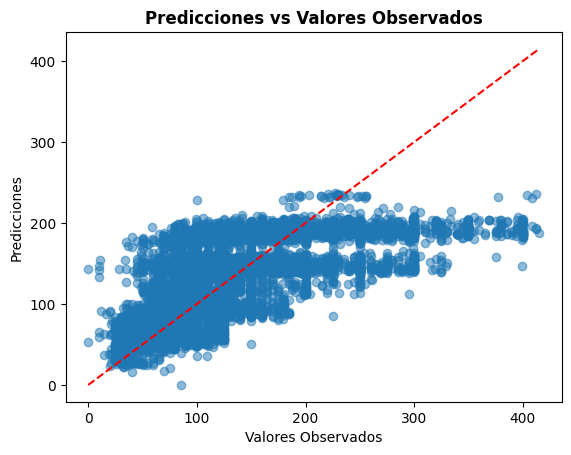

In [46]:
# Grafico de dispersión de los datos predecidos y observados
plt.scatter(y_test, y_test_pred, alpha = 0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Línea regresion
plt.xlabel("Valores Observados")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Observados",  fontweight="bold")
plt.show()